# **XGB-DQN**

# S0 Preparation
### **S0** 准备工作

Before running the code, make sure to perform the following preparation steps.
- [x] Install Anaconda
- [x] Create a new environment
- [x] Install the following Python packages in the new environment: numpy, pandas, tensorflow, xgboost, scikit-learn, scikit-optimize, ...
- [x] Run Jupyter Lab in the new environment
- [x] Navigate to this file by double-clicking on it in the file directory on the left side of Jupyter Lab 
- [x] Choose the kernel of the new environment in the top right corner of Jupyter Lab

在运行代码前，请确保完成以下准备工作：
- [x] 安装Anaconda
- [x] 创建一个新的环境
- [x] 在新环境安装以下python包：numpy, pandas, tensorflow, xgboost, scikit-learn, scikit-optimize ...
- [x] 在新环境下运行jupyter lab
- [x] 在jupyter左侧的文件夹目录下找到本文件并双击打开
- [x] 在jupyter右上角选择新环境的kernel

## **S1** Importing Python Packages
### **S1** 导入所有的python包

In [1]:
#导入常用的库
import pandas as pd 
import numpy as np
from numpy import loadtxt
import random
import tensorflow as tf
import xgboost as xgb # 1.5.0
from skopt import BayesSearchCV 
from skopt.space import Integer
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## **S2** Training the XGBoost Model
### **S2** 训练XGBoost模型

In [2]:
# 1. Read the processed CSV file, modify the file paths based on your actual file locations
# 1.读取处理后的csv文件，根据您的文件保存路径进行修改
xgb_file = r"C:\Users\111\Desktop\Cleaned_data.csv"
xgb_encode_file = r"C:\Users\111\Desktop\Cleaned_data_encode.csv"

# 2. Read the data 3. Set the timestamp format # 4. Remove missing values
# 2. 读取数据  3. 设定时间戳格式  4. 删除缺失值
data = pd.read_csv(xgb_file,encoding='gbk')
data['Date_Time'] = pd.to_datetime(data['Date_Time'])
data = data.dropna()
data = data[data != -999].dropna()
# data.head()

In [3]:
# 5. Encode non-numeric variables
# 5. 将非数值类型的变量进行编码 
dtypes_list=data.dtypes.values
columns_list=data.columns
for i in range(len(columns_list)):
    if dtypes_list[i]=='object':
        lb=LabelEncoder()
        lb.fit(data[columns_list[i]])
        data[columns_list[i]]=lb.transform(data[columns_list[i]])
data.head()

# data.to_csv(xgb_encode_file,index=False)  

,ID,Date_Time,AC_Status,Window_Status,CLast_Time,CLast_Time_T,WLast_Time,WLast_Time_T,Indoor_Temp,Indoor_RH,...,Room_ID,Study_ID,City,Next_Indoor_Temp,Next_Indoor_RH,Next_Outdoor_Temp,Next_Outdoor_RH,Differ_Outdoor_Temp,Differ_Indoor_Temp,Target_Temp
0,1,2019-03-05 00:00:00,0,0.0,0,0,0.0,0.0,25.12,70.84,...,0,6,0,25.09,71.22,26.0,84.0,0.0,-0.03,0.0
1,2,2019-03-05 01:00:00,0,0.0,0,0,0.0,0.0,25.09,71.22,...,0,6,0,25.05,71.66,26.0,89.0,0.0,-0.04,0.0
2,3,2019-03-05 02:00:00,0,0.0,0,0,0.0,0.0,25.05,71.66,...,0,6,0,25.02,71.84,26.0,89.0,0.0,-0.03,0.0
3,4,2019-03-05 03:00:00,0,0.0,0,0,0.0,0.0,25.02,71.84,...,0,6,0,24.97,72.11,25.0,89.0,-1.0,-0.05,0.0
4,5,2019-03-05 04:00:00,0,0.0,0,0,0.0,0.0,24.97,72.11,...,0,6,0,24.92,72.12,25.0,89.0,0.0,-0.05,0.0


In [4]:
# 6. Check information about the 'data' DataFrame
# 6. 检查data的信息
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42338 entries, 0 to 42932
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   42338 non-null  int64         
 1   Date_Time            42338 non-null  datetime64[ns]
 2   AC_Status            42338 non-null  int64         
 3   Window_Status        42338 non-null  float64       
 4   CLast_Time           42338 non-null  int64         
 5   CLast_Time_T         42338 non-null  int64         
 6   WLast_Time           42338 non-null  float64       
 7   WLast_Time_T         42338 non-null  float64       
 8   Indoor_Temp          42338 non-null  float64       
 9   Indoor_RH            42338 non-null  float64       
 10  Outdoor_Temp         42338 non-null  int64         
 11  Outdoor_RH           42338 non-null  int64         
 12  Rain                 42338 non-null  int32         
 13  Cloud                42338 non-null 

In [5]:
# 7. 'x' represents independent variables, 'y' represents the feature to be predicted
# 7. x是自变量，y是要被预测的特征
x = data.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
y = data['Differ_Indoor_Temp']

# 8. Split the dataset into training and testing sets
# 8. 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2022)

In [6]:
# 8. Bayesian Hyperparameter Tuning, Print the Best Parameters
# 8. 贝叶斯调参，打印最优参数
opt = BayesSearchCV(xgb.XGBRegressor(verbosity=0,
                              n_jobs=-1,
                                random_state=2022), 
                    { 
                    'max_depth': Integer(3, 5), 
                    'n_estimators': Integer(100, 500), 
                    'learning_rate': (0.1, 0.5)},
                    random_state=2022,
                    scoring='r2',
                    n_iter=20,
                    cv=3)
opt.fit(x_train, y_train)
print(f'best params: {opt.best_params_}')

best params: OrderedDict([('learning_rate', 0.23474251928691375), ('max_depth', 5), ('n_estimators', 500)])


In [7]:
# 9. Use the Best Parameters from Bayesian Hyperparameter Tuning and Train the Model
# 9. 根据贝叶斯调参的最优参数进行修改，然后开始训练
model_XGB = xgb.XGBRegressor(random_state=2000,
                            verbosity=1,
                             n_jobs=-1,
                             max_depth=5, 
                            learning_rate=0.23474, 
                            n_estimators=500)
model_XGB.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.23474, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=2000, ...)

## **S3** 定义DQN的框架

In [8]:
# Create Experience Replay Buffer
# 创建经验回放缓冲区
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# 创建DQN模型
class DQN(tf.keras.Model):
    def __init__(self):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)
        
# Create Deep Q-Network (DQN) Model
# 创建Q网络更新函数
def update_Q_network():
    states, actions, next_states, rewards = zip(*replay_buffer.sample(batch_size))
    states = np.array(states)
    actions = np.array(actions)
    next_states = np.array(next_states)
    rewards = np.array(rewards)

    with tf.GradientTape() as tape:
        Q_values = Q_network(states)
        target_Q_values = Q_network(next_states)
        target_Q_values = rewards + gamma * tf.reduce_max(target_Q_values, axis=1)
        mask = tf.one_hot(actions, num_actions)
        Q_action = tf.reduce_sum(tf.multiply(Q_values, mask), axis=1)
        loss = loss_function(target_Q_values, Q_action)

    grads = tape.gradient(loss, Q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, Q_network.trainable_variables))

# Create Target Network Update Function
# 创建目标网络更新函数
def update_target_network():
    target_network.set_weights(Q_network.get_weights())

# Create ε-Greedy Policy
# 创建ε-greedy策略
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        Q_values = Q_network(np.array([state]))
        return np.argmax(Q_values)
        
# Define Reward Function
# 定义奖励函数
def calculate_reward(state, step, action, next_state):
    reward = 0
    standard = 'ASHRAE'
    coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
    L11, L12, U12, U11 = coordinates_dict[standard][0]
    L21, L22, U22, U21 = coordinates_dict[standard][1]
    T1, T2 = coordinates_dict[standard][2]
    InT, OutT = next_state[0], next_state[2]
    if OutT <= T1:
        L1, L2, U2, U1 = L11, L12, U12, U11
    elif OutT >= T2:
        L1, L2, U2, U1 = L21, L22, U22, U21
    else:
        increase = (OutT-T1)*(L21-L11)/(T2-T1)
        L1, L2, U2, U1 = L11+increase, L12+increase, U12+increase, U11+increase
    if InT>=L2 and InT<=U2:
        reward = 0
    elif InT<L2:
        reward = -(InT-L2) ** 2
    elif InT>U2:
        reward = -(InT-U2) ** 2
    if action==0 or action==12:
        reward = reward+0
    elif action>12:
        reward = reward-2*(60*0.87*1)
    else:
        reward = reward-(60*0.87*1)
    return reward
    
# Establish Mapping between Actions and Index
# 建立action和索引的映射关系
def map_action_to_dataframe(action):
    Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = 0,0,0,0,0
    action = int(action)
    if action == 0:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 0
        WLast_Time = 0
    elif action>0 and action<12:
        Target_Temp = 19 + action
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 0
        WLast_Time = 0
    elif action == 12:
        Target_Temp = 0
        AC_Status = 0
        CLast_Time = 0
        Window_Status = 1
        WLast_Time = 60
    else:
        Target_Temp = action+7
        AC_Status = 1
        CLast_Time = 60
        Window_Status = 1
        WLast_Time = 60
    return Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time

In [9]:
# Filter Data for One Day
# 筛选出一天的数据样本
def chose_data(a,data):
    data_test00 = data[a:a+23]
    data_test0a = data_test00.reset_index(drop=True) # 备份
    data_test0 = data_test00.reset_index(drop=True)
    new_time_c = data_test0a.iloc[0]['CLast_Time_T'] - data_test0a.iloc[0]['AC_Status']*60
    data_test0.at[0,'CLast_Time_T'] = new_time_c
    new_time_w = data_test0a.iloc[0]['WLast_Time_T'] - data_test0a.iloc[0]['Window_Status']*60
    data_test0.at[0,'WLast_Time_T'] = new_time_w
    data_test = data_test0[['Indoor_Temp','Indoor_RH','Outdoor_Temp','Outdoor_RH','Rain','Cloud','Windspeed','Hour','Next_Outdoor_Temp','Next_Outdoor_RH']].copy()
    xgboost_test = data_test0.drop(['Next_Indoor_Temp','Next_Indoor_RH','Date_Time','Study_ID','Differ_Indoor_Temp','ID'],axis=1)
    return data_test,xgboost_test

## **S4** 将XGB和DQN集成并进行训练

In [10]:
episode_list = []
total_reward_list = []
best_policy = []
next_in_temp_list = []
AC_Status_List=[]
W_Status_List=[]

data_RL = data

for i in range(0,1):
    # Define Parameters
    # 定义参数
    num_features = 8
    num_actions = 24
    gamma = 0.9  # Discount factor 折扣因子
    epsilon = 1.0  # Initial exploration rate 初始探索率
    min_epsilon = 0.1  # Minimum exploration rate 最小探索率
    epsilon_decay = 0.995  # Exploration rate decay factor 探索率衰减因子，ε-greedy策略中的ε
    learning_rate = 0.001  # Learning rate 学习率，通常选择0.001有利于收敛
    memory_capacity = 10000  # Experience replay buffer capacity 经验回放缓冲区容量
    batch_size = 32  # Batch size 批量处理大小

    # Create Q-Network and Target Network
    # 创建Q网络和目标网络
    Q_network = DQN()
    target_network = DQN()
    
    # Define Loss Function and Optimizer
    # 定义损失函数和优化器
    loss_function = tf.losses.MeanSquaredError()
    optimizer = tf.optimizers.Adam(learning_rate)
    
    # Create Experience Replay Buffer
    # 创建经验回放缓冲区
    replay_buffer = ReplayBuffer(memory_capacity)

    # Train DQN
    # 训练 DQN
    data_test,xgboost_test = chose_data(i*24,data_RL)
    num_episodes = 1000
    for episode in range(num_episodes):
        episode_list.append(episode)
        data_pre_test = data_test
        xgboost_pre_test = xgboost_test
        total_reward = 0
        for step in range(6):
            xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        state = data_pre_test.iloc[6, :num_features].values  # 开始工作的初始始状态   
        for step in range(6,18):
            action = epsilon_greedy_policy(state, epsilon)
            Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
            xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
            xgboost_pre_test.at[step,'AC_Status'] = AC_Status
            xgboost_pre_test.at[step,'Window_Status'] = Window_Status
            xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
            xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
            if CLast_Time > 0:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
            else:
                xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
            if WLast_Time > 0:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
            else:
                xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
            hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
            next_differ_temp_list = model_XGB.predict(hour_row_df) 
            next_differ_temp = next_differ_temp_list[0]
            next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
            xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
            next_state = data_pre_test.iloc[step+1, :num_features].values           
            reward = calculate_reward(state,step, action, next_state)
            total_reward += reward
            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            if epsilon > min_epsilon:
                    epsilon *= epsilon_decay
            if len(replay_buffer.memory) >= batch_size:
                update_Q_network()
        total_reward_list.append(total_reward)
        
    # Training Completed, Make Decisions    
    # 训练完成，进行决策
    data_pre_test = data_test
    xgboost_pre_test = xgboost_test
    for step in range(0,6):
        if step ==0:
            temp_original = data_pre_test.iloc[step]['Indoor_Temp']
            next_in_temp_list.append(temp_original)
        best_policy.append(0)
        AC_Status_List.append(0)
        W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    state = data_pre_test.iloc[6, :num_features].values
    for step in range(6,18):
        action = epsilon_greedy_policy(state, 0)
        Target_Temp, AC_Status, Window_Status,CLast_Time,WLast_Time = map_action_to_dataframe(action)
        best_policy.append(action)
        AC_Status_List.append(AC_Status)
        W_Status_List.append(Window_Status)
        xgboost_pre_test.at[step,'Target_Temp'] = Target_Temp
        xgboost_pre_test.at[step,'AC_Status'] = AC_Status
        xgboost_pre_test.at[step,'Window_Status'] = Window_Status
        xgboost_pre_test.at[step,'CLast_Time'] = CLast_Time
        xgboost_pre_test.at[step,'WLast_Time'] = WLast_Time
        if CLast_Time > 0:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = xgboost_pre_test.iloc[step-1]['CLast_Time_T'] + CLast_Time
        else:
            xgboost_pre_test.at[step, 'CLast_Time_T'] = 0
        if WLast_Time > 0:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = xgboost_pre_test.iloc[step-1]['WLast_Time_T'] + WLast_Time
        else:
            xgboost_pre_test.at[step, 'WLast_Time_T'] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_state = data_pre_test.iloc[step+1, :num_features].values      
        state = next_state
    for step in range(18,23):
        best_policy.append(0)
        AC_Status_List.append(0)
        W_Status_List.append(0)
        xgboost_pre_test.loc[step, ['Target_Temp', 'AC_Status', 'Window_Status', 'CLast_Time', 'WLast_Time', 'CLast_Time_T', 'WLast_Time_T']] = 0
        hour_row_df = pd.DataFrame(xgboost_pre_test.iloc[step]).T
        next_differ_temp_list = model_XGB.predict(hour_row_df) 
        next_differ_temp = next_differ_temp_list[0]
        next_in_temp = xgboost_pre_test.iloc[step]['Indoor_Temp']+next_differ_temp
        xgboost_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
        next_in_temp_list.append(next_in_temp)
        data_pre_test.at[step+1,'Indoor_Temp'] = next_in_temp
    best_policy.append(0)  
    AC_Status_List.append(0)
    W_Status_List.append(0)  
    
    print(best_policy[(i)*24:(i+1)*24])
    print(next_in_temp_list[(i)*24:(i+1)*24])


[0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 12, 0, 12, 12, 12, 0, 0, 0, 0, 0, 0]
[25.12, 24.960115278959275, 24.87854640454054, 24.845297156721355, 24.82767366886139, 24.853638606965543, 24.88066441461444, 24.910615245699884, 24.997789318561555, 25.00444520486519, 25.20788216067478, 25.27956351114437, 25.57920342160389, 25.975942755471916, 26.035928530972452, 26.3258940413408, 26.75521908549592, 27.26561079768464, 27.66487307695672, 27.813868208210916, 27.845968151818962, 27.863569820653648, 28.02962603641674, 28.04167046526447]


## **S5** Visualization
### **S5** 可视化

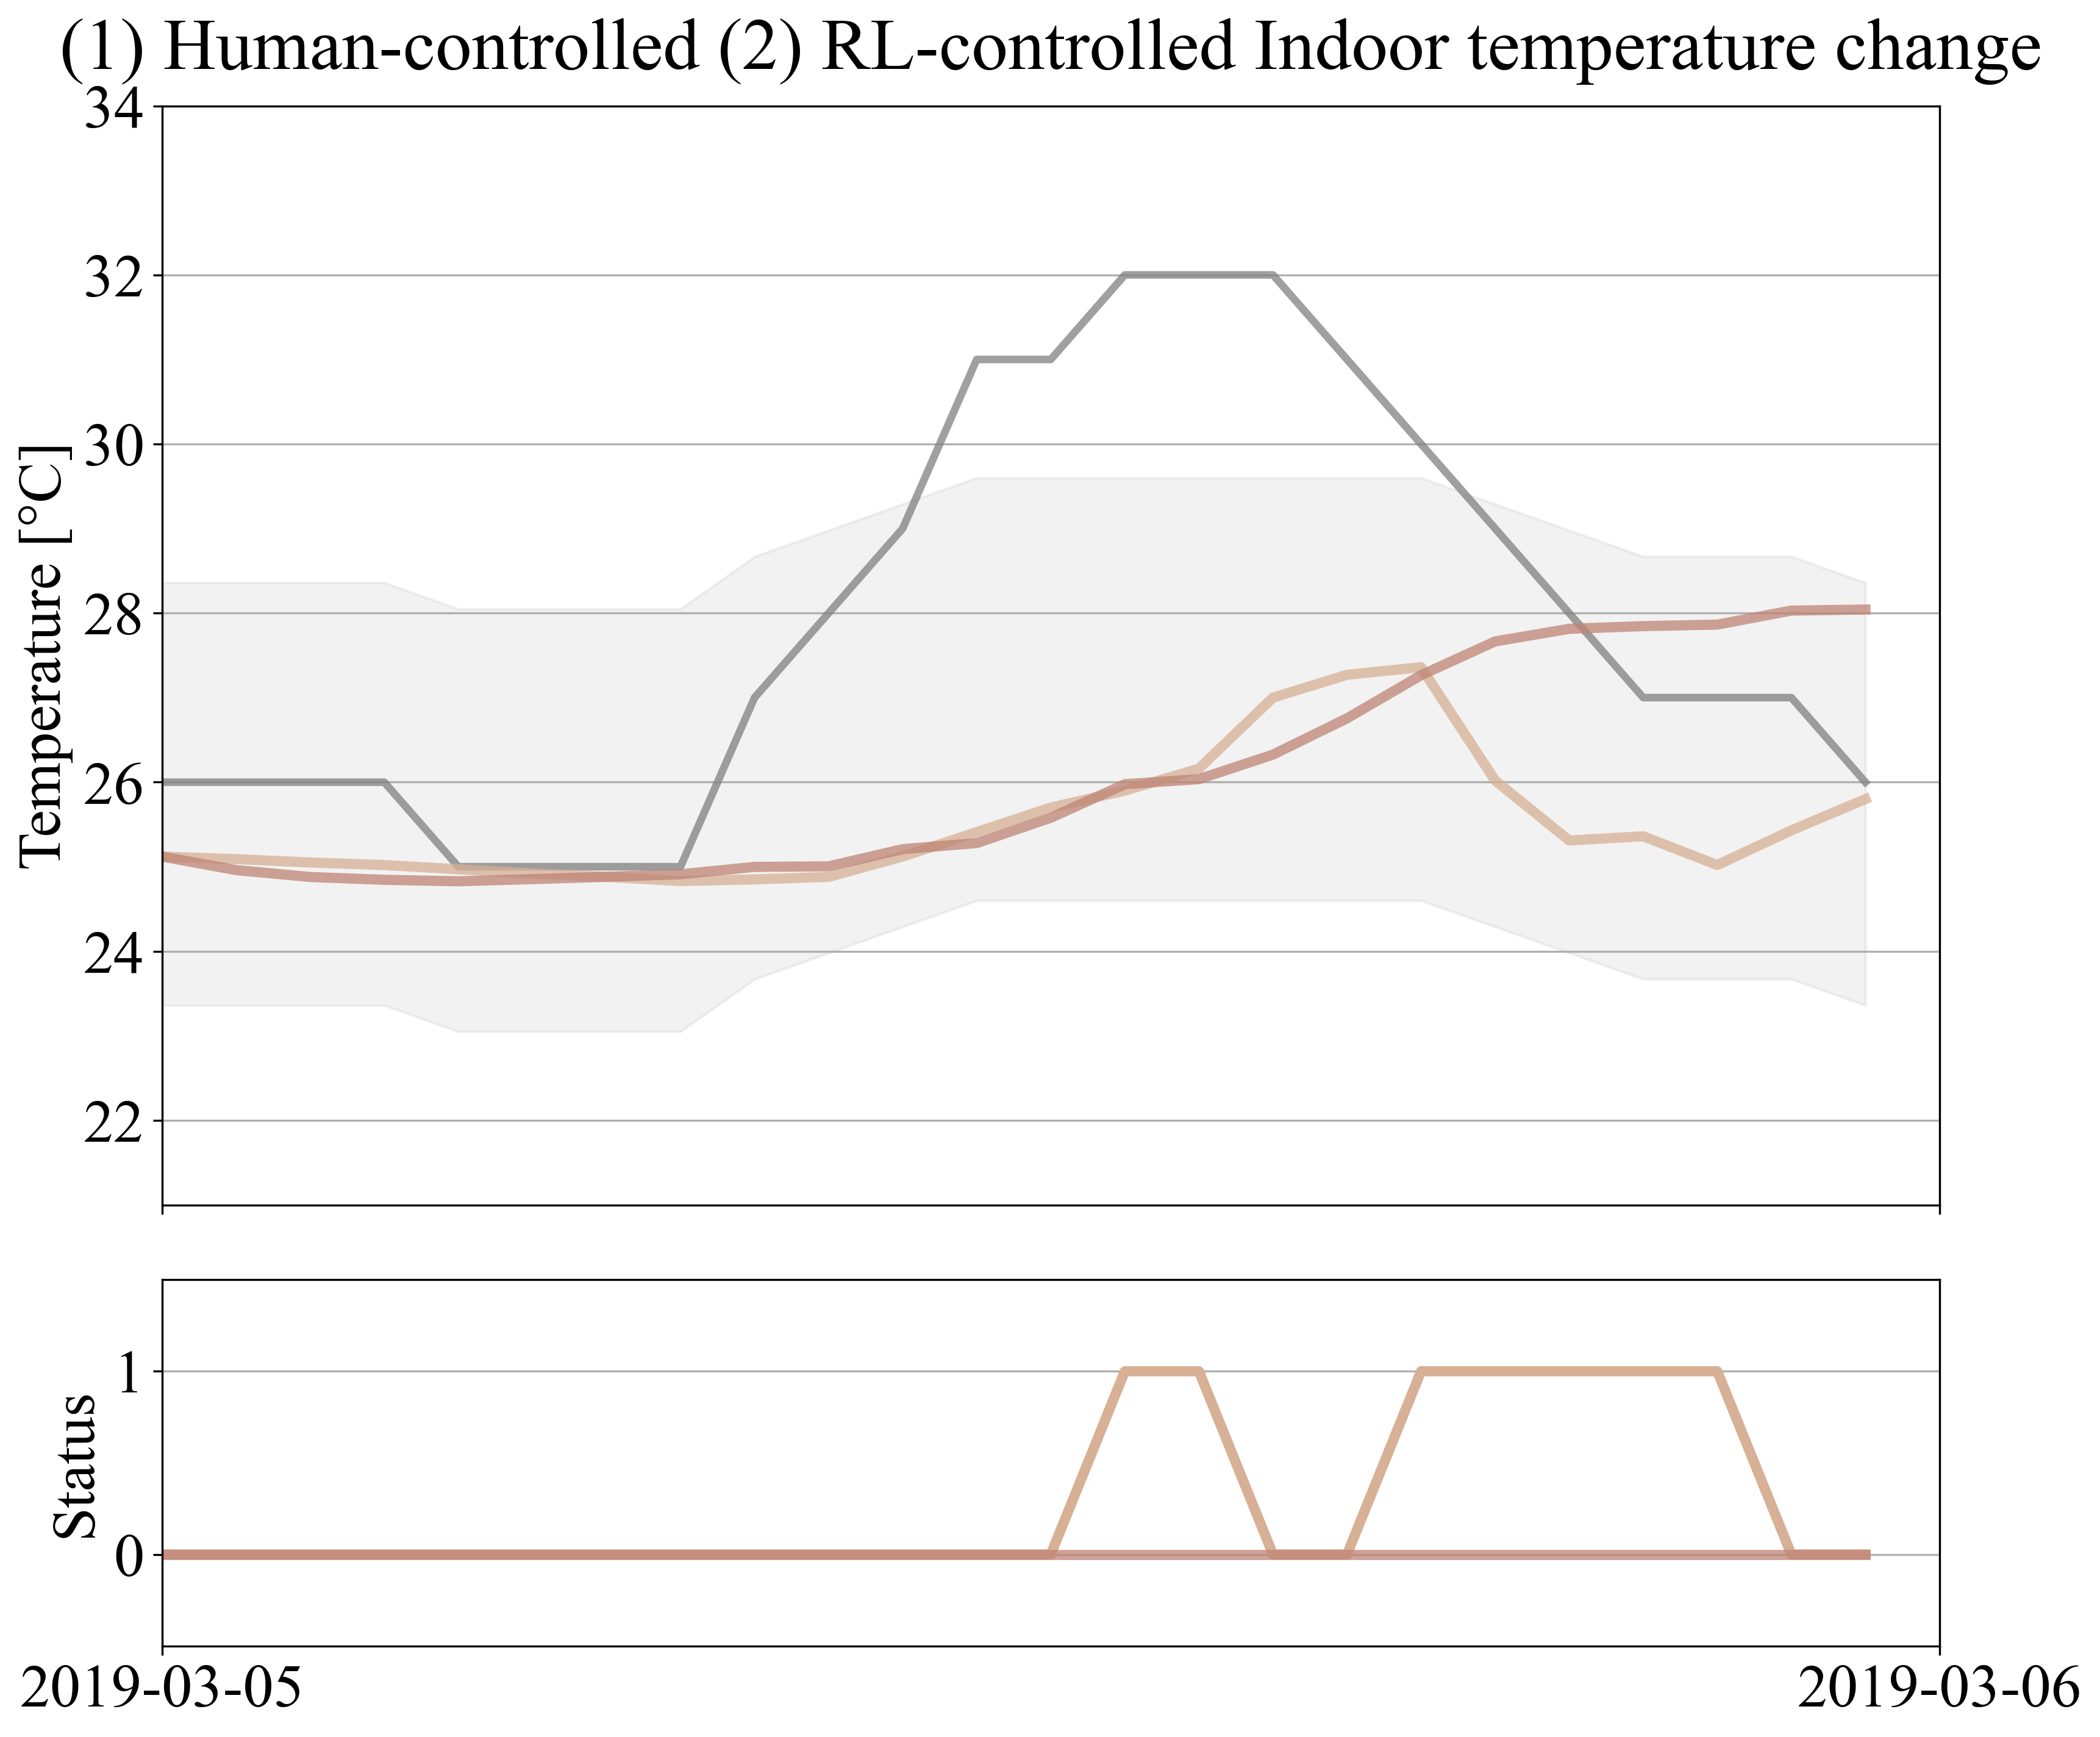

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, dates
from datetime import datetime
rc('font', family='Times New Roman', size=24)

standard = 'ASHRAE'
coordinates_dict = {'ASHRAE': [[17.4, 18.4, 23.4, 24.4], [23.6, 24.6, 29.6, 30.6], [10, 30]]}
L11, L12, U12, U11 = coordinates_dict[standard][0]
L21, L22, U22, U21 = coordinates_dict[standard][1]
T1, T2 = coordinates_dict[standard][2]

data_or_ = pd.read_csv(xgb_file)
data_or = data_or_[:24]
OutT = data_or['Outdoor_Temp']
data_or['Date_Time'] = pd.to_datetime(data_or['Date_Time'])
data_or = data_or.sort_values(by='Date_Time')
data_or.set_index('Date_Time', inplace=True)
UP = []
LO = []
for temp in OutT:
    if temp <= T1:
        L1, L2, U2, U1 = L11, L12, U12, U11
    elif temp >= T2:
        L1, L2, U2, U1 = L21, L22, U22, U21
    else:
        increase = (temp - T1) * (L21 - L11) / (T2 - T1)
        L1, L2, U2, U1 = L11 + increase, L12 + increase, U12 + increase, U11 + increase
    UP.append(U1-1)
    LO.append(L1+1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot Temperature Change Line Chart
# 绘制温度变化折线图
ax1.plot(data_or.index, data_or['Outdoor_Temp'], label='Outdoor_Temp', color='gray', alpha=0.75, linewidth=3)
ax1.plot(data_or.index, data_or['Indoor_Temp'], linestyle='-', linewidth=4, label='(2) Human-controlled', color='#d7b095', alpha=0.75)
ax1.fill_between(data_or.index, LO, UP, color='grey', alpha=0.1, label='Comfort Zone', interpolate=True)
ax1.plot(data_or.index, next_in_temp_list, linestyle='-', linewidth=4, label='RL-controlled', color='#bf8375', alpha=0.75)

date_format = dates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_major_locator(dates.DayLocator(interval=1))
ax1.tick_params(axis='x', rotation=0)
ax1.set_title('(1) Human-controlled (2) RL-controlled Indoor temperature change',y=1.02)
ax1.set_ylabel('Temperature [°C]')
ax1.grid(True)
ax1.set_ylim(21, 34)
ax1.set_xlim(datetime(2019, 3, 5), datetime(2019, 3, 6))

# Plot Air Conditioning Status Line Chart
# 绘制空调状态折线图
ax2.plot(data_or.index, data_or['AC_Status'], linestyle='-', linewidth=4, label='AC_status', color='#d7b095', alpha=1)
ax2.plot(data_or.index, AC_Status_List, linestyle='-', linewidth=4, label='AC_Status_List', color='#bf8375', alpha=0.75)
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_locator(dates.DayLocator(interval=1))
ax2.tick_params(axis='x', rotation=0)
ax2.set_ylabel('Status')
ax2.grid(True)
ax2.set_ylim(-0.5, 1.5)
ax2.set_xlim(datetime(2019, 3, 5), datetime(2019, 3, 6))

plt.tight_layout()
plt.show()